In [1]:
#First, some imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import progressbar
import h5py
%matplotlib inline

In [2]:
def get_data(N):
    assert N<=25000, "N must be less than 25000"
    with h5py.File("./data/ising_data.h5",'r') as F:
        data = F['data'][:N, ...,0]*1.0
        label = F['energy'][:N, ...]*1.0
    return data, label

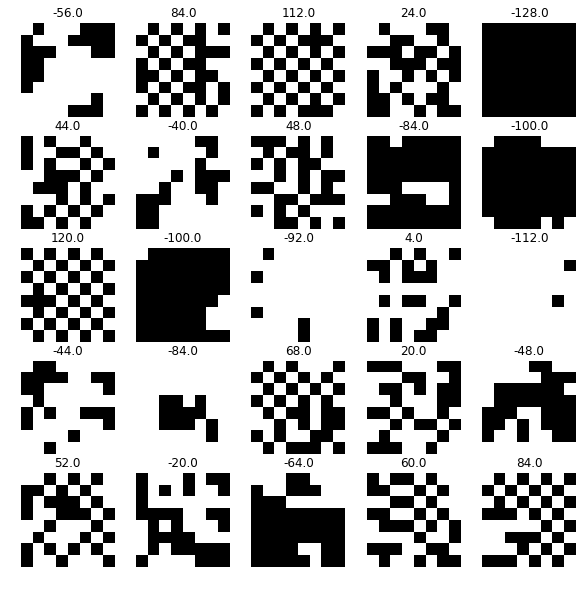

In [3]:
data, labels =  get_data(25)
fig, axs = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        axs[i][j].imshow(data[5*i+j,:,:], cmap='gray')
        axs[i][j].set_title('{0}'.format(labels[5*i+j][0]))
        axs[i][j].axis("off")

In [4]:
L = 8
f = 4
c = 1

In [5]:
# %load ednn.py
class EDNN_helper(object):
    
    def __init__(self, L, f, c):
        assert f <= L/2, "Focus must be less than half the image size to use this implementation."
        assert (f + 2*c) <= L, "Total tile size (f+2c) is larger than input image."
        self.l = L
        self.f = f
        self.c = c
    
    def __roll(self, in_, num, axis):
        """author: Kyle Mills"""
        D = tf.transpose(in_, perm=[axis, 1-axis])  #if axis=1, transpose first
        D = tf.concat([D[num:, :], D[0:num, :]], axis=0)
        return tf.transpose(D, perm=[axis, 1-axis]) #if axis=1, transpose back

    def __slice(self, in_, x1, y1, w, h): 
        """author: Kyle Mills"""
        return in_[x1:x1+w, y1:y1+h]

    def ednn_split(self, in_): 
        """author: Kyle Mills"""
        l = self.l
        f = self.f
        c = self.c

        tiles = []
        for iTile in range(l/f):
            for jTile in range(l/f):
                #calculate the indices of the centre of this tile (i.e. the centre of the focus region)
                cot = (iTile*f + f/2, jTile*f + f/2) #centre of tile
                foc_centered = in_ 
                #shift the picture, wrapping the image around,
                #so that the focus is centered in the middle of the image
                foc_centered = self.__roll(foc_centered, l/2-cot[0], 0)
                foc_centered = self.__roll(foc_centered, l/2-cot[1], 1)
                #Finally slice away the excess image that we don't want to appear in this tile
                final = self.__slice(foc_centered, l/2-f/2-c, l/2-f/2-c, 2*c+f, 2*c+f)
                tiles.append(final)

        return tf.expand_dims(tiles, axis=3)

In [6]:
def NN(_in):
    tile_size = f + 2*c
    _in = tf.reshape(_in, (-1, tile_size**2))
    nn = tf.contrib.layers.fully_connected(_in, 32)
    nn = tf.contrib.layers.fully_connected(nn, 1, activation_fn=None)
    return nn

In [7]:
tf.reset_default_graph()
#data comes in a [ batch * L * L ] tensor, and labels a [ batch * 1] tensor
x = tf.placeholder(tf.float32, (None, L, L), name='input_image')
y = tf.placeholder(tf.float32, (None, 1))

helper = EDNN_helper(L=L, f=f, c=c)

#Then the EDNN-specific code:
tiles = tf.map_fn(helper.ednn_split, x, back_prop=False)
tiles = tf.transpose(tiles, perm=[1,0,2,3,4])
output = tf.map_fn(NN, tiles, back_prop=True)
output = tf.transpose(output, perm=[1,0,2])
predicted = tf.reduce_sum(output, axis=1)


#define the loss function
loss = tf.reduce_mean(tf.square(y-predicted))

#create an optimizer, a training op, and an init op
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [8]:
data, labels = get_data(2500)
train_data = data[:2000]
test_data = data[2000:]
train_labels = labels[:2000]
test_labels = labels[2000:]

In [9]:
sess = tf.InteractiveSession()
sess.run(init)

In [10]:
BATCH_SIZE = 500

bar = progressbar.ProgressBar()
for epoch in bar(range(500-168)):
    for batch in xrange(train_data.shape[0] / BATCH_SIZE):
        _, loss_val = sess.run([train_step, loss],
                               feed_dict={
                                    x: train_data[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE],
                                    y: train_labels[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE]
                                }
                              )


100% (332 of 332) |#######################| Elapsed Time: 0:01:51 Time: 0:01:51


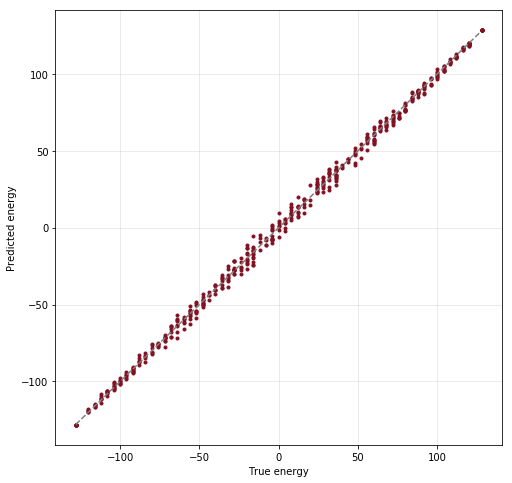

The median absolute error is 1.65842437744


In [11]:
prediction = sess.run(predicted, feed_dict={x: test_data})

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(test_labels.flatten(), prediction.flatten(), '.', color='#821122')
ax.plot(np.arange(-128,128), np.arange(-128,128), '--', color='gray')
ax.set_xlabel("True energy")
ax.set_ylabel("Predicted energy")
ax.grid(alpha=0.3)
plt.show()
print "The median absolute error is", np.median(np.abs(test_labels-prediction))

Train for another 500 epochs with more examples, to get better accuracy for future use (about 30 minutes to run on GPU)

In [12]:
if False: #comment out this line if you want it to run
    data, labels = get_data(25000)
    train_data = data[:20000]
    test_data = data[20000:]
    train_labels = labels[:20000]
    test_labels = labels[20000:]



    BATCH_SIZE = 500

    bar = progressbar.ProgressBar()
    for epoch in bar(range(500)):
        for batch in xrange(train_data.shape[0] / BATCH_SIZE):
            _, loss_val = sess.run([train_step, loss],
                                   feed_dict={
                                        x: train_data[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE],
                                        y: train_labels[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE]
                                    }
                                  )
    saver = tf.train.Saver()
    saver.save(sess, "./checkpoints/ednn_2_Ising/model_trained_more")

    prediction = sess.run(predicted, feed_dict={x: test_data})

    fig, ax = plt.subplots(1,1, figsize=(8,8))
    ax.plot(test_labels.flatten(), prediction.flatten(), '.', color='#821122')
    ax.plot(np.arange(-128,128), np.arange(-128,128), '--', color='gray')
    ax.set_xlabel("True energy")
    ax.set_ylabel("Predicted energy")
    ax.grid(alpha=0.3)
    plt.show()
    print "The median absolute error is", np.median(np.abs(test_labels-prediction))

